# Ctc matrix decoding 

# ---------------------------------

# TLDR:
## TRANSCRIPT -> "тридцать"
## DECODED -> "твецать"
#### Aim - find right TRANSCRIPT in ctc matrix

# ---------------------------------

Задача: speech to text

Метод решения: mozilla DS (acoustic model + greedy decoder).

Проблема: иногда s2t модель коверкает слова (transcript->decoded) "тридцать"->"твецать", "стандарт"->"ктандар", "восемь"->"вобесемь" и т. д. Коверкание заключается в том, что неправильным (иногда похожим фонетически) буквами присваивается высокая вероятность, а правильным низкая. Модель расшифровывает услышанное, как будто бы это произносит маленький ребенок. s2t модель присваивает вероятности всем буквам алфавита на каждом time stamp.

Hipotesis: В ctc матрице всегда найдутся правильные буквы; последовательность которая из них получается имеет не топовую но и не самую низкую вероятность. Она где то посередине. 
Если взять топ 5 символов по вероятности на каждом time stamp то среди них можно найти нужное слово.



Проблема: получается много неправильных последовательностей

ИТОГО: получилось что искать правильные слова в ctc матрице можно. Но Выбирать их всех похожих на правильные - отдельная проблема

In [50]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from Levenshtein import distance as levenshtein_distance

In [34]:
def plot_ctc_matrix(cm,cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    t12 = ['space', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', '%']
    plt.xticks(list(range(1, cm.shape[1], 1)))
    plt.yticks(range(len(t12)), t12)
    fmt = '.2f'
    thresh = 0.01
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] > thresh:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

def greedy_decoder(ctc, alphabet):
    alphabet_size = len(alphabet)
    arg_max = np.argmax(ctc, axis=1)
    repeat_filter = arg_max[1:] != arg_max[:-1]
    repeat_filter = np.concatenate([[True], repeat_filter])
    collapsed = arg_max[repeat_filter]
    return collapsed

def top_n_max(series, top=2, diraction=max):
    series = list(set(series.tolist()))
    if diraction == max:
        top_result = sorted(series)[-top:]
    else:
        top_result = sorted(series)[:top]
    return top_result

def lm(s, w, top=1, ngram=False):
    """
    return: next top_n most probable word(s)
    """
    t = {}
    for k, v in w.items():
        if k.split('<>')[1] == s:
            t.update({k.split('<>')[0]: v})
    t = {k: v for k, v in sorted(t.items(), key=lambda item: item[1], reverse=True)}
    result = {}
    i = 0
    for k, v in t.items():
        result.update({k: v})
        i += 1
        if i == top:
            break
    return result

Аккустическая модель расшифровала слово "тридцать" как "твецать" (если применять greedy decoder)

In [36]:
ctc = np.load('/Users/georgychernousov/Desktop/ctc_output/ctc_output_2021-11-17 15:25:16.739723.npy')[0]
ctc_transposed = np.transpose(ctc)
al = [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', '%']
print(''.join([al[i] for i in np.argmax(ctc[185:205], axis=1)]), '--->', ''.join([al[i] for i in greedy_decoder(ctc[185:205], al) if i != 33]))


  т%в%е%%%%%ц%аатть  --->  твецать 


По ctc-матрице видно наиболее вероятные буквы

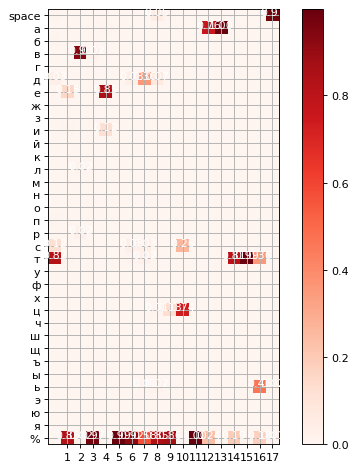

In [4]:
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plot_ctc_matrix(ctc_transposed[:,187:205]) # 180:260
plt.grid()
plt.show()

Выведем топ 5 букв по вероятности на каждом time stamp (вероятности от большей к меньшей справа налево)

In [136]:
for letter in range(187, 205, 1): # 4, 253
    top = top_n_max(ctc_transposed[:,letter:letter+1].reshape(34,), top=5)
    print(letter, [al[list(ctc_transposed[:,letter:letter+1]).index(i)] for i in top])

187 ['б', ' ', 'д', 'с', 'т']
188 ['х', 'т', 'и', 'е', '%']
189 ['е', 'л', 'р', '%', 'в']
190 ['а', 'и', 'л', 'в', '%']
191 ['я', 'а', 'ы', 'и', 'е']
192 ['е', 'с', 'в', 'д', '%']
193 ['м', 'т', 'д', 'с', '%']
194 ['ь', 'т', 'с', 'д', '%']
195 ['ц', 'ь', ' ', 'д', '%']
196 ['е', 'с', ' ', 'ц', '%']
197 ['%', 'а', 'т', 'с', 'ц']
198 ['с', 'о', 'т', 'а', '%']
199 [' ', 'з', 'о', '%', 'а']
200 ['%', 'ы', 'я', 'о', 'а']
201 ['н', 'й', 'м', '%', 'т']
202 ['н', 'м', 'ь', '%', 'т']
203 ['н', ' ', '%', 'т', 'ь']
204 ['ч', 'т', '%', 'ь', ' ']


Однако среди топ 5 букв есть нужная последовательность которая была прооизнесена на аудио

![alt text](img.png "Title")

Вероятности этих букв настолько меньше (можно видеть по тепловой карте) что во время декодинга матрицы beam search методом нужные последовательности просто вымываются 

Найдем все места где по мнению greedy decoder-а стоит пробел

In [38]:
spaces = []
wait = False
arg_max = np.argmax(ctc, axis=1)
for t, i in enumerate(arg_max):
    if wait:
        if i in [0, 33] and (arg_max[t+1] != 0 or arg_max[t+1] != 33):
            spaces[-1].append(t)
            continue
        else:
            wait = False
    try:
        if i == 0 and not wait and arg_max[t+1] in [0, 33]:
            spaces.append([t])
            wait = True
        elif i != 0 and not wait and arg_max[t+1] in [0] and arg_max[t+2] not in [0]:
            spaces.append([t])
    except IndexError: # in case index is out of bounds
        continue 

Теперь мы знаем все пробелы ctc матрицы в терминах time stamp

In [17]:
spaces

[[55, 56, 57, 58, 59, 60],
 [74, 75, 76, 77],
 [107, 108],
 [120, 121, 122, 123],
 [131],
 [159],
 [160, 161],
 [167],
 [168, 169],
 [185, 186],
 [204, 205],
 [228, 229, 230, 231],
 [285, 286, 287, 288],
 [297, 298],
 [325, 326, 327],
 [355, 356, 357],
 [385, 386, 387],
 [397, 398, 399, 400],
 [424, 425, 426],
 [442, 443],
 [472, 473]]

Найдем начало и конец искомого слова в ctc матрице (Это осложняетя повторением букв ии наличием blank символа)

In [39]:
word = 'твецать'
def foo(w):
    w_ = ''
    for n, i in enumerate(w):
        if n != 0:
            if w_[-1] != i:
                w_ += i
        else:
            w_ += i
    return w_
def locate_ctc(arg_max, greedy_word):
    argmax_slice = 0
    word = ''
    position = []
    for i in range(len(arg_max)):
        if i not in spaces[argmax_slice]:
            word += al[arg_max[i]] if al[arg_max[i]] != '%' and al[arg_max[i]] != ' ' else ''
            position.append(i)
            if foo(word) == greedy_word:
                break
        else:
            word = ''
            position = []
            argmax_slice += 1
    return position
ctc_word_position = locate_ctc(np.argmax(ctc, axis=1), word)
print(ctc_word_position)
start = ctc_word_position[0]
end = ctc_word_position[-1]
print(''.join([al[i] for i in arg_max[start:end]]))# .index(' к%%%%%т%%а%%'))

[186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203]
 т%в%е%%%%%ц%аатт


Возьмем весь корпус слов используемого домена. Наберем в переменную splitted_corpus все слова из корпуса но обрезанные по длине от 1 до длины искомого слова

In [40]:
import json
with open('/Users/georgychernousov/pat_2021_sept/1_gram_lm.json') as json_file:
    w = json.load(json_file)
corpus = []
for k in w.keys():
    for i in k.split('<>'):
        corpus.append(i) if '<' not in i else None
corpus = list(set(corpus))
print(type(corpus), len(corpus), corpus[10:15])
splitted_corpus = {}
for i in range(len(word)+5):
    splitted_corpus.update({i+1:[]})
    for ii in corpus:
        splitted_corpus[i+1].append(ii[:i+1])

<class 'list'> 2745 ['розовых', 'опухолевые', 'кластеров', 'многочисленными', 'экзофитный']


Соберем все вероятные последовательности которые можно составить из 18 наборов по 5 букв (очевидно что таких комбинаций будет 5**18 степени (3814697265625 шт). Чтобы этого избежать - оставляем только те, что есть в нашей языковой марковской мобели)

In [48]:
import numpy as np
al = [' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', '%']

A_next = {start-1: ['']}
weights = {}
c = 0
for letter in range(start, end, 1): # 205
    top = top_n_max(ctc_transposed[:,letter:letter+1].reshape(34,), top=5)
    alphabet = [al[list(ctc_transposed[:,letter:letter+1]).index(i)] for i in top]
    al_top = dict(zip(alphabet, top))
    new_strings = []
    A_next.update({letter: []})
    for ph in A_next[letter-1]:
        for l in alphabet:
            if l != '%':
                add = ph + l
                if add in splitted_corpus[len(add)]:
                    A_next[letter].append(add)
                    weights.update({add: al_top[l]})
            elif l == '%':
                A_next[letter].append(ph)
    print(len(A_next[letter]))
    

4
8
19
47
91
83
122
180
249
283
348
496
755
925
1156
1696
2403


# Расстояние левенштейна

Судя по расстоянию Левенштейна самые близкие слова к искомому слову - нужные 

In [53]:
result = {}
for i in list(set(A_next[list(A_next.keys())[-1]])):
    if lm(i, w, top=1) != {}:
        result.update({i: levenshtein_distance(i, word)})
{k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

{'двадцать': 3,
 'тридцать': 3,
 'девять': 4,
 'десять': 4,
 'тела': 4,
 'семь': 5,
 'теле': 5,
 'та': 5,
 'дата': 5,
 'триста': 5,
 'серая': 5,
 'слева': 5,
 'два': 5,
 'две': 5,
 'белый': 6,
 'следы': 6,
 'бледо': 6,
 'белые': 6,
 'серый': 6,
 'псевдо': 6,
 'три': 6,
 'белесо': 6,
 'без': 6,
 'слизь': 6,
 'серые': 6,
 'срезы': 6,
 'стри': 7,
 'белесый': 7,
 'семьсот': 7,
 'для': 7,
 'девятьсот': 7,
 'семьдесят': 8}

# Перемножить вероятности ctc матрицы найденных букв

Посчитаем куммулятивные вероятности из ctc матрицы этих слов

для слова "твецать"

<AxesSubplot:>

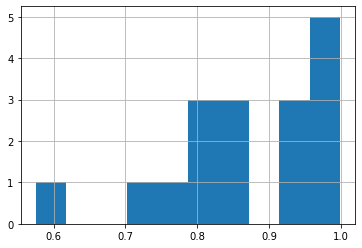

In [124]:
import pandas as pd
ctc_probas_1 = [max(i) for i in ctc[start:end]]
pd.Series(ctc_probas_1).hist()

In [186]:
np.prod(ctc_probas_1)

0.08564907

для слова "тридцать"

т 0.001506983069702983
р 0.8192211985588074
% 0.8292792439460754
р 0.019735047593712807
и 0.0008473359630443156
д 0.12393978238105774
д 0.0019630854949355125
% 0.9200761914253235
% 0.575206995010376
ц 0.011284144595265388
% 0.8588422536849976
а 6.931575626367703e-05
т 0.000186350749572739
% 0.2408692091703415
% 1.7950498659047298e-05
% 0.19228558242321014
ь 0.0006141709163784981


<AxesSubplot:>

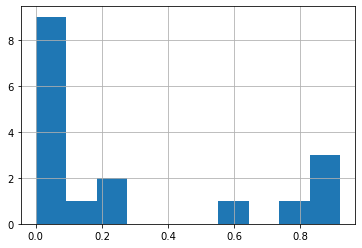

In [181]:
word = 'тридцать'
current_letter = word[0]
current_letter_ind = 0
ctc_probas_2 = []
for letter in range(start, end, 1):
    top = top_n_max(ctc_transposed[:,letter:letter+1].reshape(34,), top=5)
    letters_top = [al[list(ctc_transposed[:,letter:letter+1]).index(i)] for i in top]
    if current_letter in letters_top:
        try:
            print(current_letter, top[letters_top.index(current_letter)])
            ctc_probas_2.append(top[letters_top.index(current_letter)])
            current_letter_ind += 1
            current_letter = word[current_letter_ind]
        except IndexError:
            current_letter_ind -= 1
            # break
    elif '%' in letters_top or word[current_letter_ind-1] in letters_top:
        try:
            print('%', top[letters_top.index('%')])
            ctc_probas_2.append(top[letters_top.index('%')])
        except ValueError:
            print(current_letter, top[letters_top.index(word[current_letter_ind-1])])
            ctc_probas_2.append(top[letters_top.index(word[current_letter_ind-1])])
    elif ' ' in letters_top:
        print('space', top[letters_top.index(word[current_letter_ind-1])])
        ctc_probas_2.append(top[letters_top.index(' ')])
    else:
        print('letter pass')
pd.Series(ctc_probas_2).hist()


In [187]:
np.prod(ctc_probas_2) < np.prod(ctc_probas_1)

True

для слова "десять"

% 0.049048468470573425
д 0.027814336121082306
е 0.14937801659107208
% 0.024215776473283768
% 0.9737982749938965
с 0.8536779284477234
с 0.0012529866071417928
% 0.9200761914253235
% 0.575206995010376
% 0.8461370468139648
% 0.8588422536849976
% 6.404768646461889e-05
% 0.9984669089317322
% 0.2408692091703415
я 6.467534694820642e-05
т 0.8075715899467468
ь 0.0006141709163784981


<AxesSubplot:>

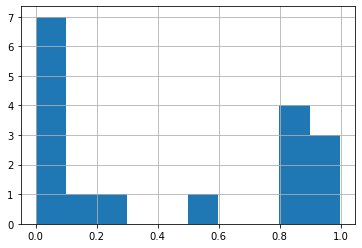

In [188]:
word = 'десять'
current_letter = word[0]
current_letter_ind = 0
ctc_probas_3 = []
for letter in range(start, end, 1):
    top = top_n_max(ctc_transposed[:,letter:letter+1].reshape(34,), top=5)
    letters_top = [al[list(ctc_transposed[:,letter:letter+1]).index(i)] for i in top]
    if current_letter in letters_top:
        try:
            print(current_letter, top[letters_top.index(current_letter)])
            ctc_probas_3.append(top[letters_top.index(current_letter)])
            current_letter_ind += 1
            current_letter = word[current_letter_ind]
        except IndexError:
            current_letter_ind -= 1
            # break
    elif '%' in letters_top or word[current_letter_ind-1] in letters_top:
        try:
            print('%', top[letters_top.index('%')])
            ctc_probas_3.append(top[letters_top.index('%')])
        except ValueError:
            print(current_letter, top[letters_top.index(word[current_letter_ind-1])])
            ctc_probas_3.append(top[letters_top.index(word[current_letter_ind-1])])
    elif ' ' in letters_top:
        ctc_probas_3.append(top[letters_top.index(' ')])
    else:
        pass
pd.Series(ctc_probas_3).hist()


In [189]:
np.prod(ctc_probas_3) < np.prod(ctc_probas_2)

False

In [190]:
np.prod(ctc_probas_3), np.prod(ctc_probas_2)

(9.768283177829464e-22, 1.4090973287668378e-31)

для слова "тела"

т 0.001506983069702983
е 0.8192211985588074
е 0.14937801659107208
л 0.015083624981343746
а 0.0005233562551438808
а 0.008024519309401512
% 0.9942909479141235
% 0.9200761914253235
% 0.575206995010376
% 0.8461370468139648
% 0.8588422536849976
а 6.931575626367703e-05
а 0.0012575250584632158
а 0.7576540112495422
а 0.9991201758384705
% 0.19228558242321014
% 0.005748456809669733


<AxesSubplot:>

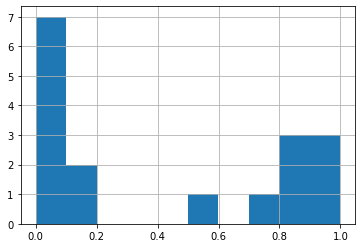

In [171]:
word = 'тела'
current_letter = word[0]
current_letter_ind = 0
ctc_probas_4 = []
for letter in range(start, end, 1):
    top = top_n_max(ctc_transposed[:,letter:letter+1].reshape(34,), top=5)
    letters_top = [al[list(ctc_transposed[:,letter:letter+1]).index(i)] for i in top]
    if current_letter in letters_top:
        try:
            print(current_letter, top[letters_top.index(current_letter)])
            ctc_probas_4.append(top[letters_top.index(current_letter)])
            current_letter_ind += 1
            current_letter = word[current_letter_ind]
        except IndexError:
            current_letter_ind -= 1
            # break
    elif '%' in letters_top or word[current_letter_ind-1] in letters_top:
        try:
            print('%', top[letters_top.index('%')])
            ctc_probas_4.append(top[letters_top.index('%')])
        except ValueError:
            print(current_letter, top[letters_top.index(word[current_letter_ind-1])])
            ctc_probas_4.append(top[letters_top.index(word[current_letter_ind-1])])
    elif ' ' in letters_top:
        ctc_probas_4.append(top[letters_top.index(' ')])
    else:
        print('letter pass')
pd.Series(ctc_probas_4).hist()


In [172]:
np.prod(ctc_probas_4)

3.2581361639485254e-22

In [174]:
np.prod(ctc_probas_2)

1.4090973287668378e-31